## CIFAR10 Spectra

In this notebook, we are exclusively interested in the power law spectral properties of the Krotov and Hopfield model in case of the CIFAR10 data set

In [121]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
# hyper-parameter
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000

model_path = Path("../data/models/CIFAR10_PowerLaw")

model_ps = {
    "in_size": 3*32**2,
    "hidden_size": 2000,
    "n": 4.5,
    "p": 3.0,
    "tau_l": 1.0 / 0.02, # 1 / learning_rate
    "k": 2,
    "Delta": 0.4,
    "R": 1.0,
}

In [7]:
# initialize the krotov hopfield model
khlayer = LocalLearning.FKHL3(model_ps, sigma=1.0)
khlayer.to(device=device)

FKHL3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [8]:
training_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=model_ps["p"],
)

dataloader_train = LocalLearning.DeviceDataLoader(
    training_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

Files already downloaded and verified


In [13]:
# training
lr = 1.0 / model_ps["tau_l"]
def learning_rate(epoch: int) -> float:
    return (1.0 - epoch / NUMBER_OF_EPOCHS) * lr

LocalLearning.train_unsupervised(
    dataloader_train,
    khlayer,
    device,
    model_path,
    no_epochs=NUMBER_OF_EPOCHS,
    checkpt_period=NUMBER_OF_EPOCHS,
    learning_rate=learning_rate,
)

torch.save(
    {
        "model_state_dict": khlayer.state_dict(),
        "model_parameters": khlayer.param_dict(),
        "device_type": device.type,
    },
    model_path / Path("kh_cifar10.pty"),
)

Training time [epochs]: 100%|███████████████████████████████████████████████████| 1000/1000 [04:40<00:00,  3.56epoch/s]


## Spectrum

In [14]:
with torch.no_grad():
    khlayer.eval()

In [16]:
test_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified


In [57]:
from torchvision import datasets
from torch import nn

class GaussianCIFAR10(datasets.CIFAR10):
    def __init__(
        self, 
        params: dict,
        train: bool=True,
        **kwargs,
    ):
        # params = {
        #   "mu": 0.0,
        #   "sigma": 1.0,
        # }
        self.mu = params["mu"]
        self.sigma = params["sigma"]
        
        # dimensions of the CIFAR10 dataset
        # 60 000 samples in total
        self.img_width_px = 32
        self.img_height_px = 32
        self.img_ch_num = 3
        
        if train:
            self.len = 50000
            
        else:
            self.len = 10000
            
        #self.data = torch.rand(
        #    (self.len, self.img_width_px, self.img_height_px, self.img_ch_num, ),
        #)
        #self.data = self.data.normal_(mean=self.mu, std=self.sigma)
        
        #self.targets = torch.zeros((self.len, 1, ))
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        
        img_gauss = torch.rand(
            (self.img_width_px, self.img_height_px, self.img_ch_num, ),
        )
        img_gauss = img_gauss.normal_(mean=self.mu, std=self.sigma)
        
        dummy_target = torch.Tensor([0.0])
        #return self.data[index], self.targets[index]
        return img_gauss, dummy_target
    
class IdentityModel(nn.Module):
    
    def __init__(self, **kwargs):
        super(IdentityModel, self).__init__()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        return self.flatten(x)

In [58]:
from torch.utils.data import DataLoader

gauss_noise_params = {"mu": 0.0, "sigma": 1.0} # standard normal Wiener process
gauss_data = GaussianCIFAR10(gauss_noise_params, train=False)

dataloader_gauss = DataLoader(
    gauss_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

In [187]:
def MinMaxNorm(x: np.array) -> np.array:
    mi = np.amin(x)
    ma = np.amax(x)
    if np.abs(ma - mi) < 1e-8:
        return np.zeros(x.shape)
    return (x - mi) / (ma - mi)

def display_model_weights(model: LocalLearning.FKHL3, Kx=30, Ky=20, fig_width_in=12.9, fig_height_in=10.0):
    with torch.no_grad():
        # extract weight matrix from model and convert to numpy array
        W = model.W.detach().cpu().clone().numpy()
        W = W.T
        # randomly choose Kx*Ky hidden entries
        W = W[np.random.choice(W.shape[0], Kx*Ky, replace=False)]

    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
    yy=0
    HM=np.zeros((32*Ky, 32*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*32:(y+1)*32,x*32:(x+1)*32, :]=MinMaxNorm(W[yy].reshape(32, 32, 3))
            yy += 1

    nc=np.amax(np.absolute(HM))
    im=ax.imshow(HM,cmap='bwr')#,vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    ax.axis('off')
    
    return fig, ax

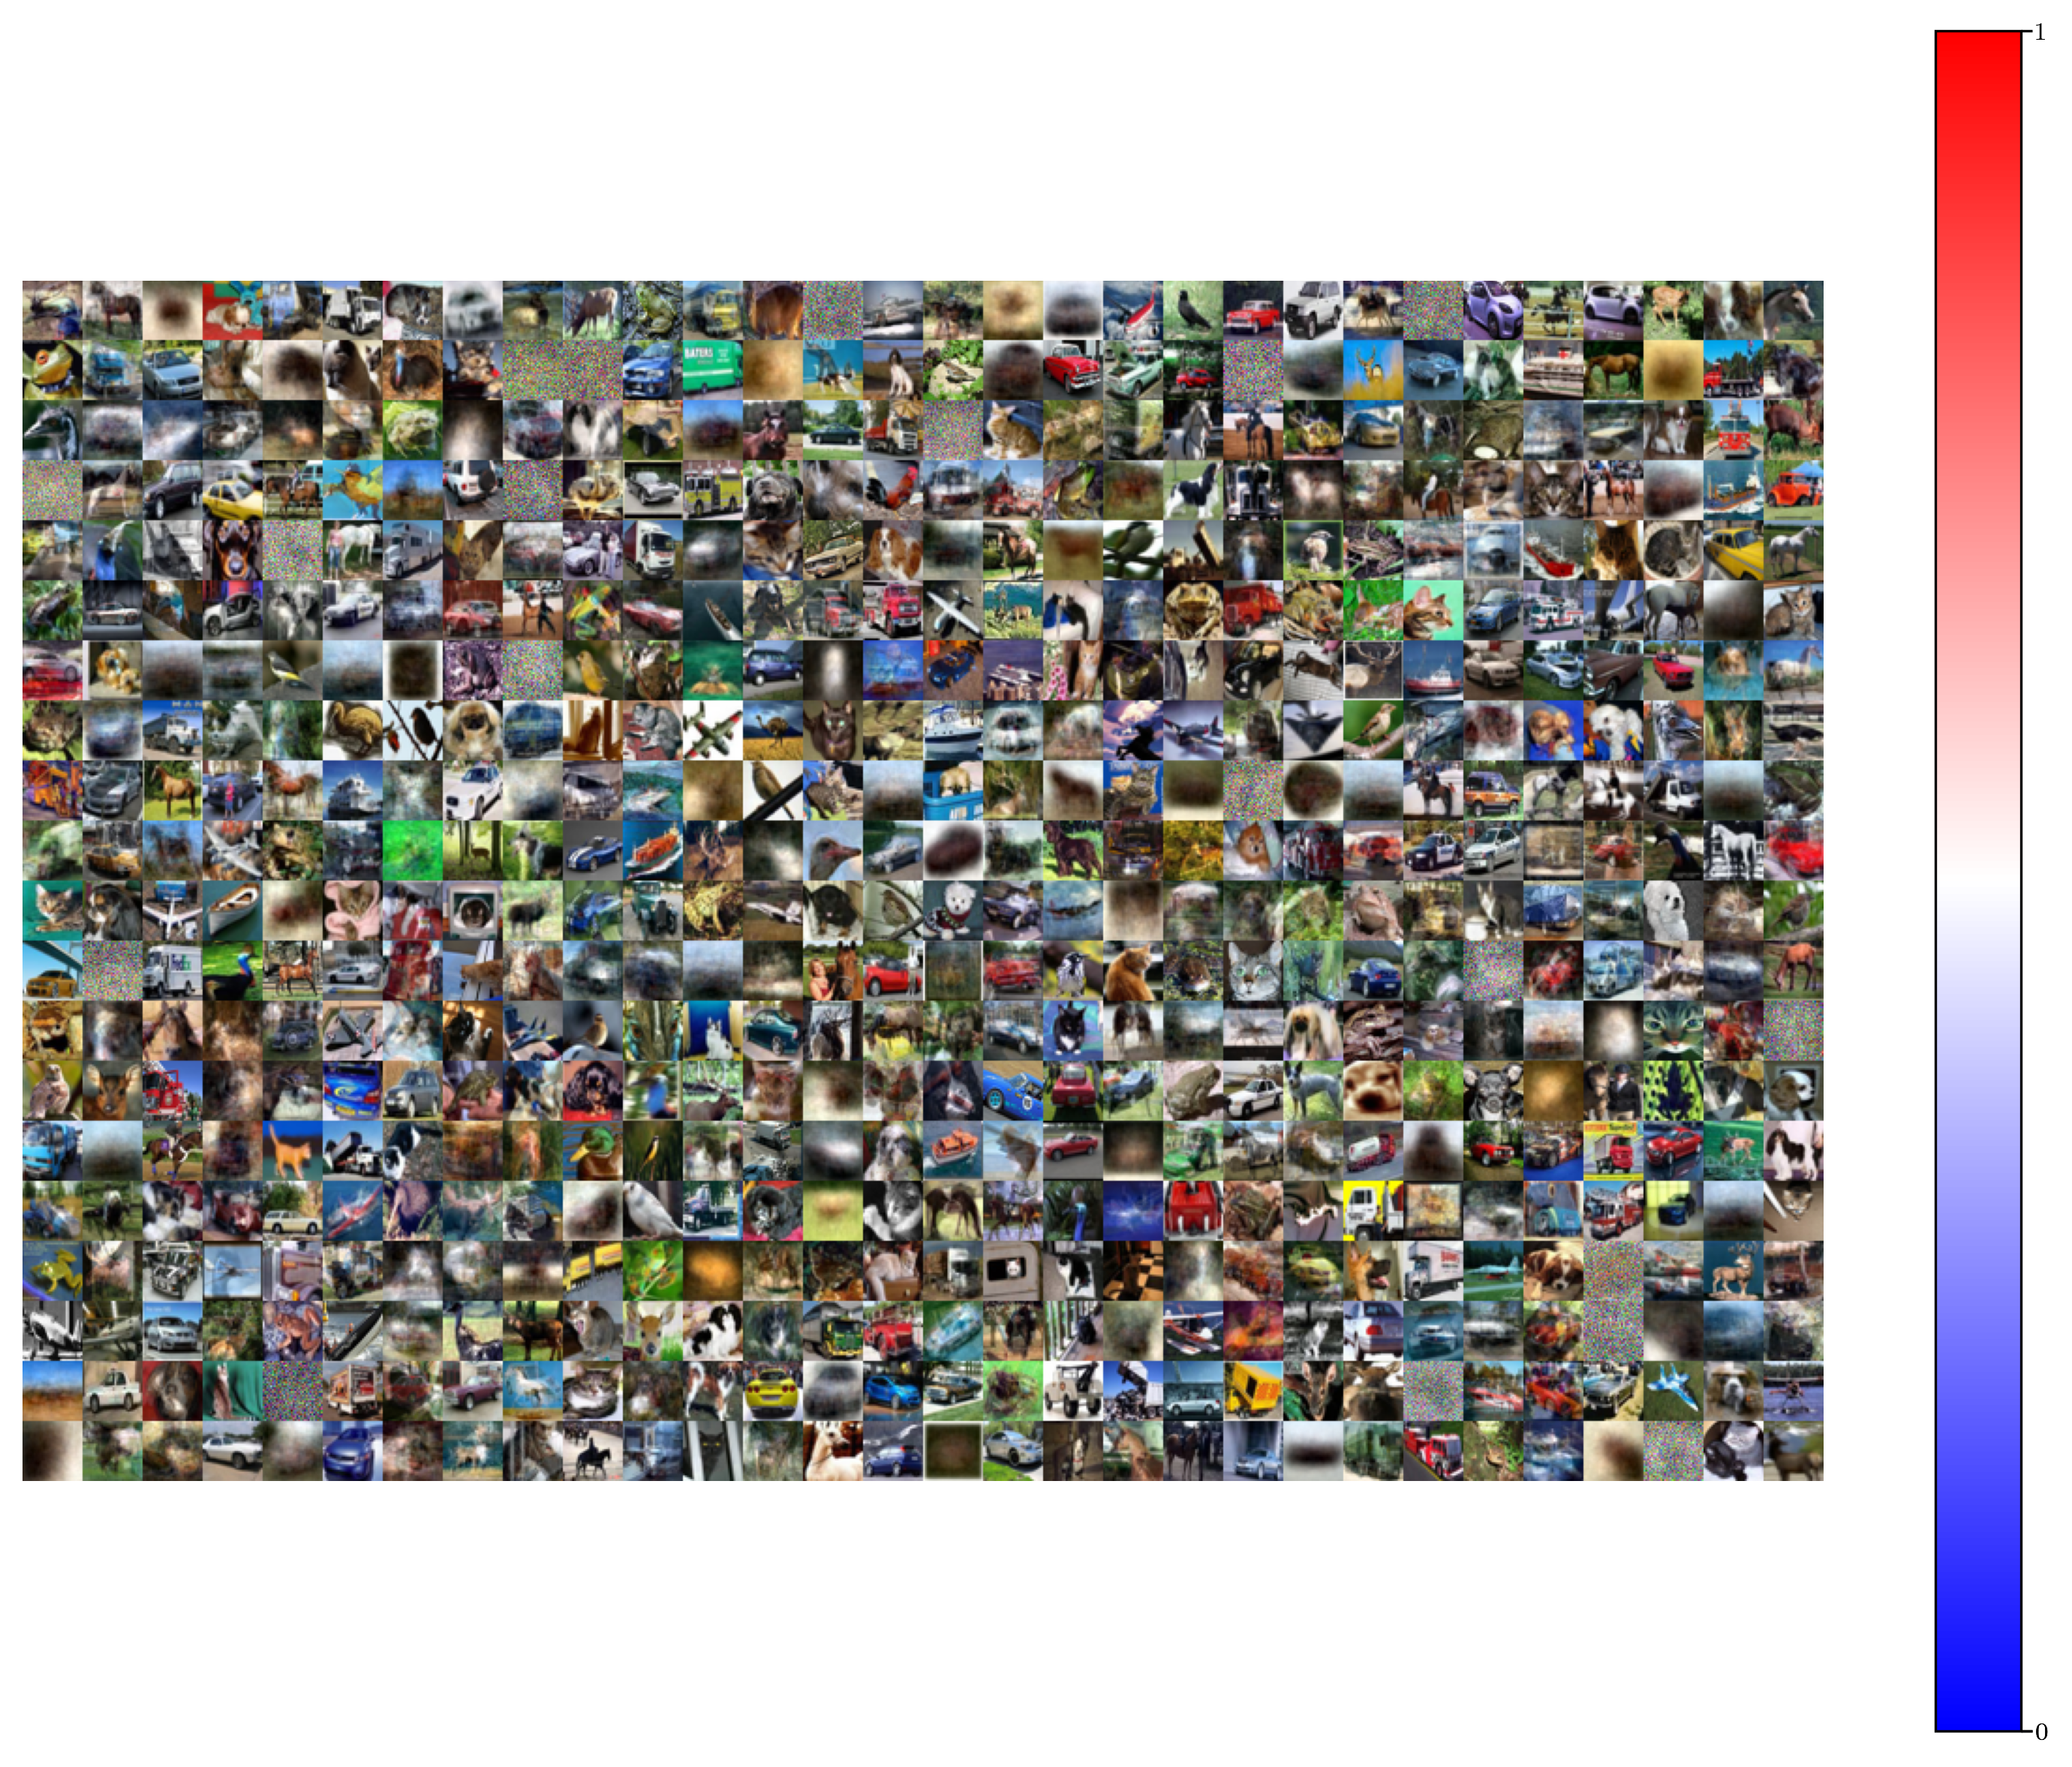

In [188]:
fig, ax = display_model_weights(khlayer)
plt.show()

In [102]:
# save the weight matrix of the model outside of the model
W = khlayer.W.clone()
h_sizes = [10, 50, 100, 500, 1000, 1500, 2000]
spectra_cifar = []
spectra_gauss = []
for h_size in h_sizes:
    
    model_ps["hidden_size"] = h_size
    khlayer_r = LocalLearning.FKHL3(model_ps, sigma=1.0)
    khlayer_r.W = nn.Parameter(W[:, :h_size])
    khlayer.to(device)
    khlayer.eval()
    
    with torch.no_grad():
        l_n_trained_cifar = l_n_trained_cifar = LocalLearning.cov_spectrum(dataloader_test, khlayer_r, device)
        l_n_trained_cifar = l_n_trained_cifar.detach().cpu().clone().numpy()
        spectra_cifar.append(l_n_trained_cifar)
        
        l_n_trained_gauss = LocalLearning.cov_spectrum(dataloader_gauss, khlayer_r, device)
        l_n_trained_gauss = l_n_trained_gauss.detach().cpu().clone().numpy()
        spectra_gauss.append(l_n_trained_gauss)

Calculating covariance spectrum: 100%|██████████████████████████████████████████████| 10/10 [00:00<00:00, 29.35batch/s]


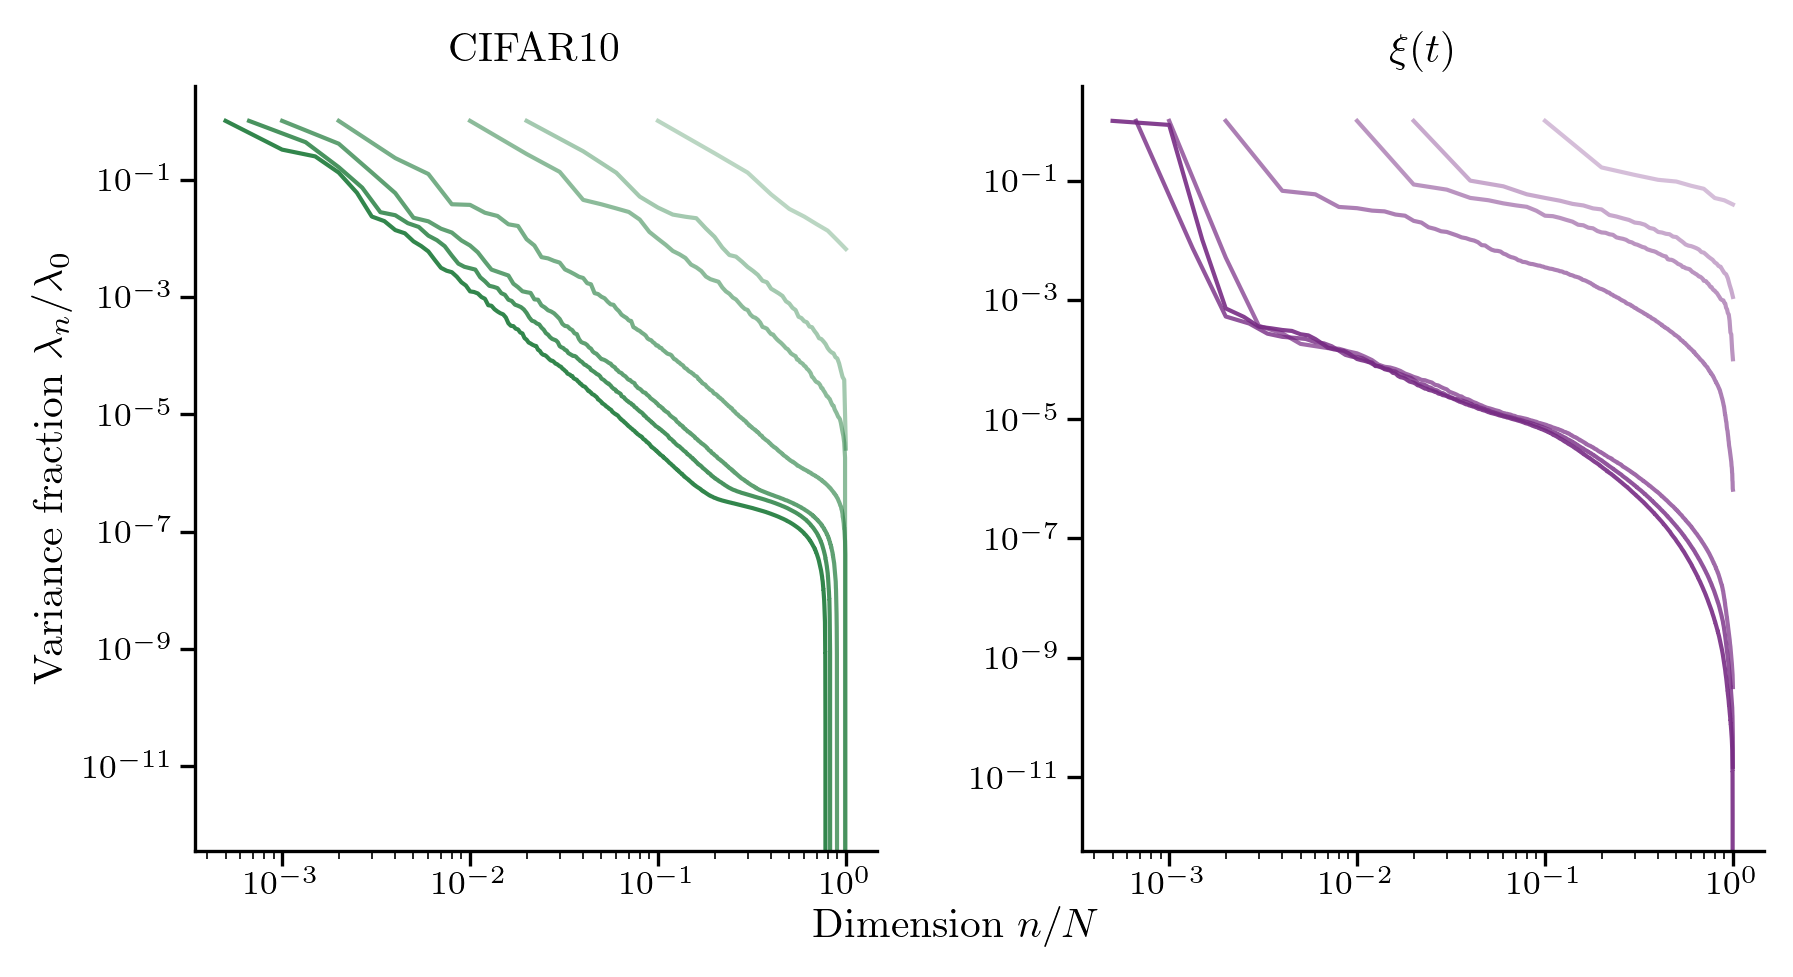

In [112]:
def well_balanced_alpha_gradient(index: int, series_length: int) -> float:
    # well balanced alpha range for line plots: 30%-100%
    return 0.3 + 0.7*index / series_length

fig, axs = plt.subplots(1, 2)
for i, (cifar_spectrum, gauss_spectrum) in enumerate(zip(spectra_cifar, spectra_gauss)):
    cs = cifar_spectrum.copy()
    gs = gauss_spectrum.copy()
    
    # renormalize the x range
    n = np.arange(1, len(gs) + 1)
    n = np.divide(n, float(n[-1]))
    
    # renormalize the spectral data
    cs /= cs[0]
    gs /= gs[0]
    
    alpha = well_balanced_alpha_gradient(i, len(spectra_gauss))
    axs[0].loglog(n, cs, "-", color='#1b7837', alpha=alpha)
    axs[1].loglog(n, gs, "-", color='#762a83', alpha=alpha)

#ax.loglog(n, l_n_trained_gauss)
fig.title(r"")
fig.text(0.5, 0.04, r"Dimension $n / N$", ha='center')
axs[0].set_ylabel(r"Variance fraction $\lambda_{n} / \lambda_{0}$")
axs[0].set_title(r"CIFAR10")
axs[1].set_title(r"$\xi(t)$")
plt.show()

## Why the step?

Why do we see the step in the covariance spectrum of the white noise source?
Potential reasons:
* we see in the weights, that some "images" appear very noisy -> maybe those contribute to the first components with highest variance -> test for that by eliminating them

### First method - eigenvector projection

In general, the model predicts $\eta$ from $\xi$ by $$\eta = W\, \xi$$.
In the following, we assume $\mathbb{E}[\xi] = \mathbb{E}[\eta] = 0$. 
Otherwise, the data can be shiftet accordingly so this holds true. 
Then,
$$C_{\eta} = \mathbb{E}[\eta^{T} \eta] = W \mathbb{\eta^{T} \eta} W^{T} = W C_{\xi} W^{T}$$.
Since $\xi$ is gaussian white noise, $$C_{\xi} = \sigma^{2} \mathbb{1}$$ with $\sigma$ denoting the standard deviation of the fluctuations in $\xi$.

With PCA, we find the eigenvectors $Q$ that diagonalize $Q\, C_{\eta}$ $$ Q\, \text{diag}(\Lambda)\, Q^{\dagger} = W C_{\xi} W^{T} = \sigma^{2} W\, W^{T}$$
such that 
$$\text{diag}(\Lambda) = Q^{\dagger}\, W\, W^{T} Q$$, thus

$Q^{\dagger}$ projects the weight matrix $W$ to the PCA space.
Thus, by selecting singular eigenvectors, we can actually build a projection matrix that eliminates those contributions that correspond to the high variance spectral components.
However, unfortunately, this does strictly only work for $W\, W^{T}$.
**Maybe, we can project W by using its inverse? -> check for prove**

## Important insight

If the signal is gaussian noise, $C_{\eta} = W\, W^{T}$. Consequently, high variance contributions in $C_{\eta}$ directly correspond to high variance contributions in $W$. 

**Prune the randomly appearing images by hand / automatically (variance clus)

In [137]:
def covariance(
    dataloader: DataLoader, 
    model: nn.Module,
    device: torch.device,
    dtype: torch.dtype=torch.float32,
) -> torch.Tensor:
    """
    Calculate covariance matrix on shifted data to increase computational stability
    """
    with torch.no_grad():
        noE = model.pSet["hidden_size"]
        
        # initialize stat tensors
        auto_corr = torch.zeros((noE, noE,), device=device, dtype=dtype)
        mean = torch.zeros((noE,), device=device, dtype=dtype)
        pop_size = 0
        
        # shift = estimate of the mean
        f, _ = next(iter(dataloader))
        K = f.mean()
        
        with tqdm(dataloader, unit="batch") as ttest:
            ttest.set_description(f"Calculating covariance matrix")
            for x, _ in ttest:
                pop_size += len(x)
                pred = model(x.to(device))
                data = pred - K
                auto_corr += data.T @ data
                mean += data.sum(axis=0)
                
        cov = auto_corr - mean[None].T @ mean[None] / pop_size
        cov /= pop_size - 1
        
        return cov

In [138]:
cov_gauss = covariance(dataloader_gauss, khlayer, device)

  0%|          | 0/10 [00:00<?, ?batch/s]

In [154]:
l_n_gauss, Q = torch.linalg.eigh(cov_gauss, UPLO='U')
l_n_gauss, indices = torch.sort(l_n_gauss, descending=True)
Q_ord = Q[indices]

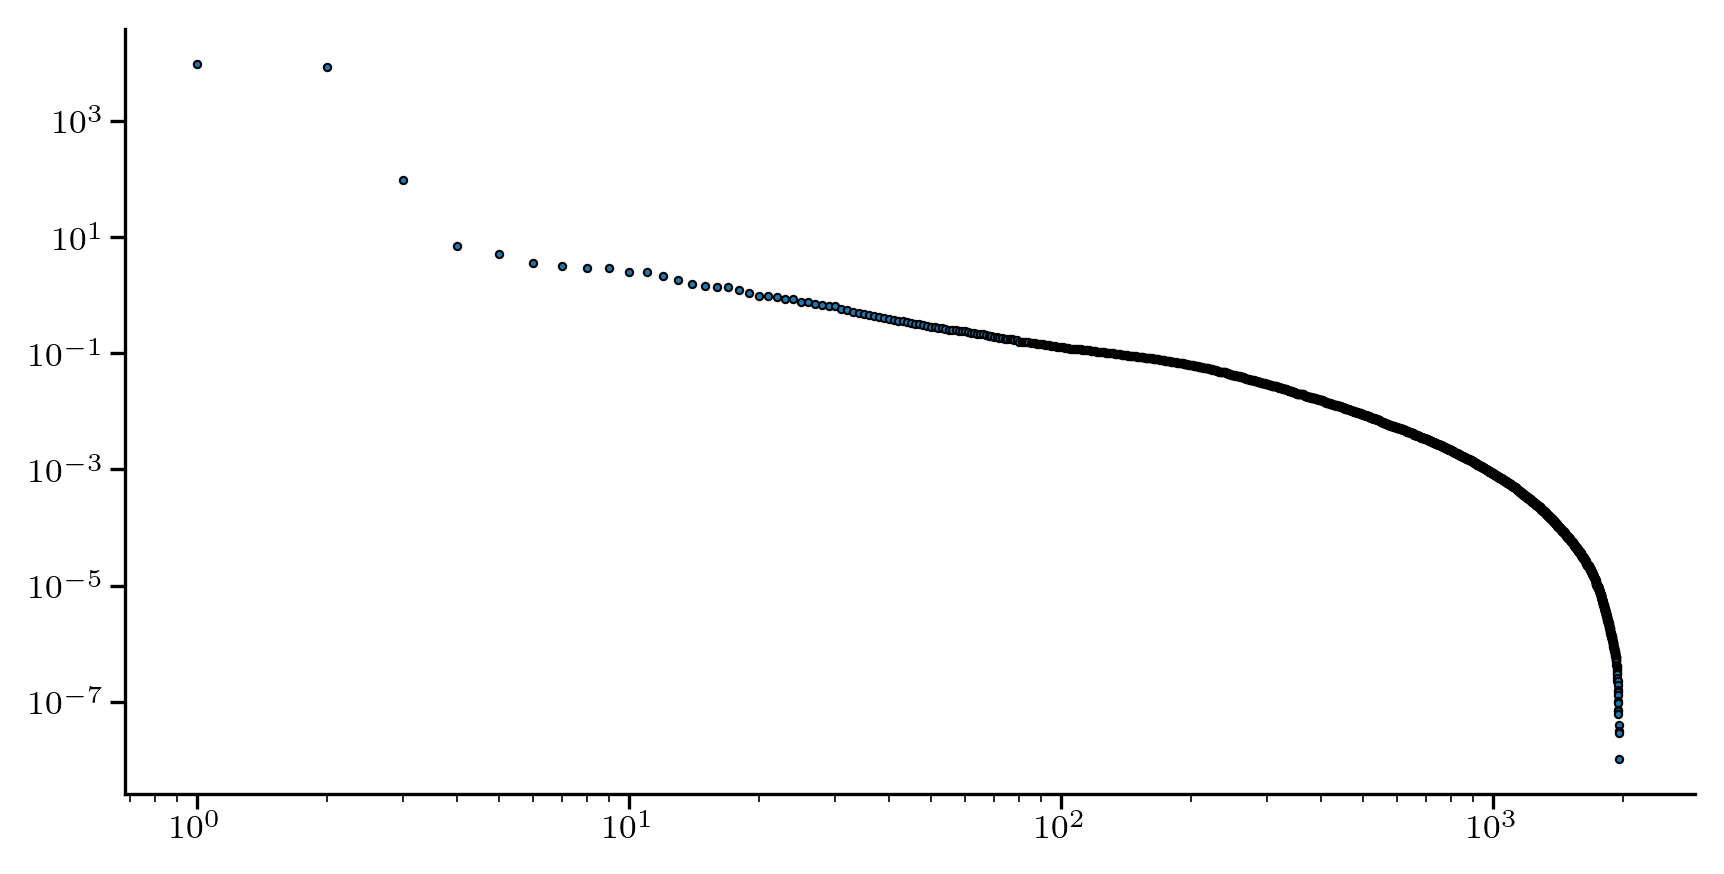

In [164]:
fig, ax = plt.subplots()
l_n_gauss_np = l_n_gauss.detach().cpu().clone().numpy()
n = np.arange(1, len(l_n_gauss_np) + 1)
ax.loglog(n, l_n_gauss_np, ".")
plt.show()

In [157]:
W = khlayer.W.clone()

In [181]:
P_dom = Q_ord.clone()
P_dom[3:] = torch.zeros((len(Q_ord[0]) - 3, len(Q_ord[0]), ))

P_orth = Q_ord.clone()
P_orth[:3] = torch.zeros((3, len(Q_ord[0]), ))

In [230]:
W_dom = P_dom @ W.T
W_orth = P_orth @ W.T

In [226]:
def display_weights(W: torch.Tensor, Kx=30, Ky=20, fig_width_in=12.9, fig_height_in=10.0):
    W = W.detach().cpu().clone().numpy()
    
    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
    yy=0
    HM=np.zeros((32*Ky, 32*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*32:(y+1)*32,x*32:(x+1)*32, :]=MinMaxNorm(W[yy].reshape(32, 32, 3))
            yy += 1

    nc=np.amax(np.absolute(HM))
    im=ax.imshow(HM,cmap='bwr')#,vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    ax.axis('off')
    
    return fig, ax

ValueError: cannot reshape array of size 2000 into shape (32,32,3)

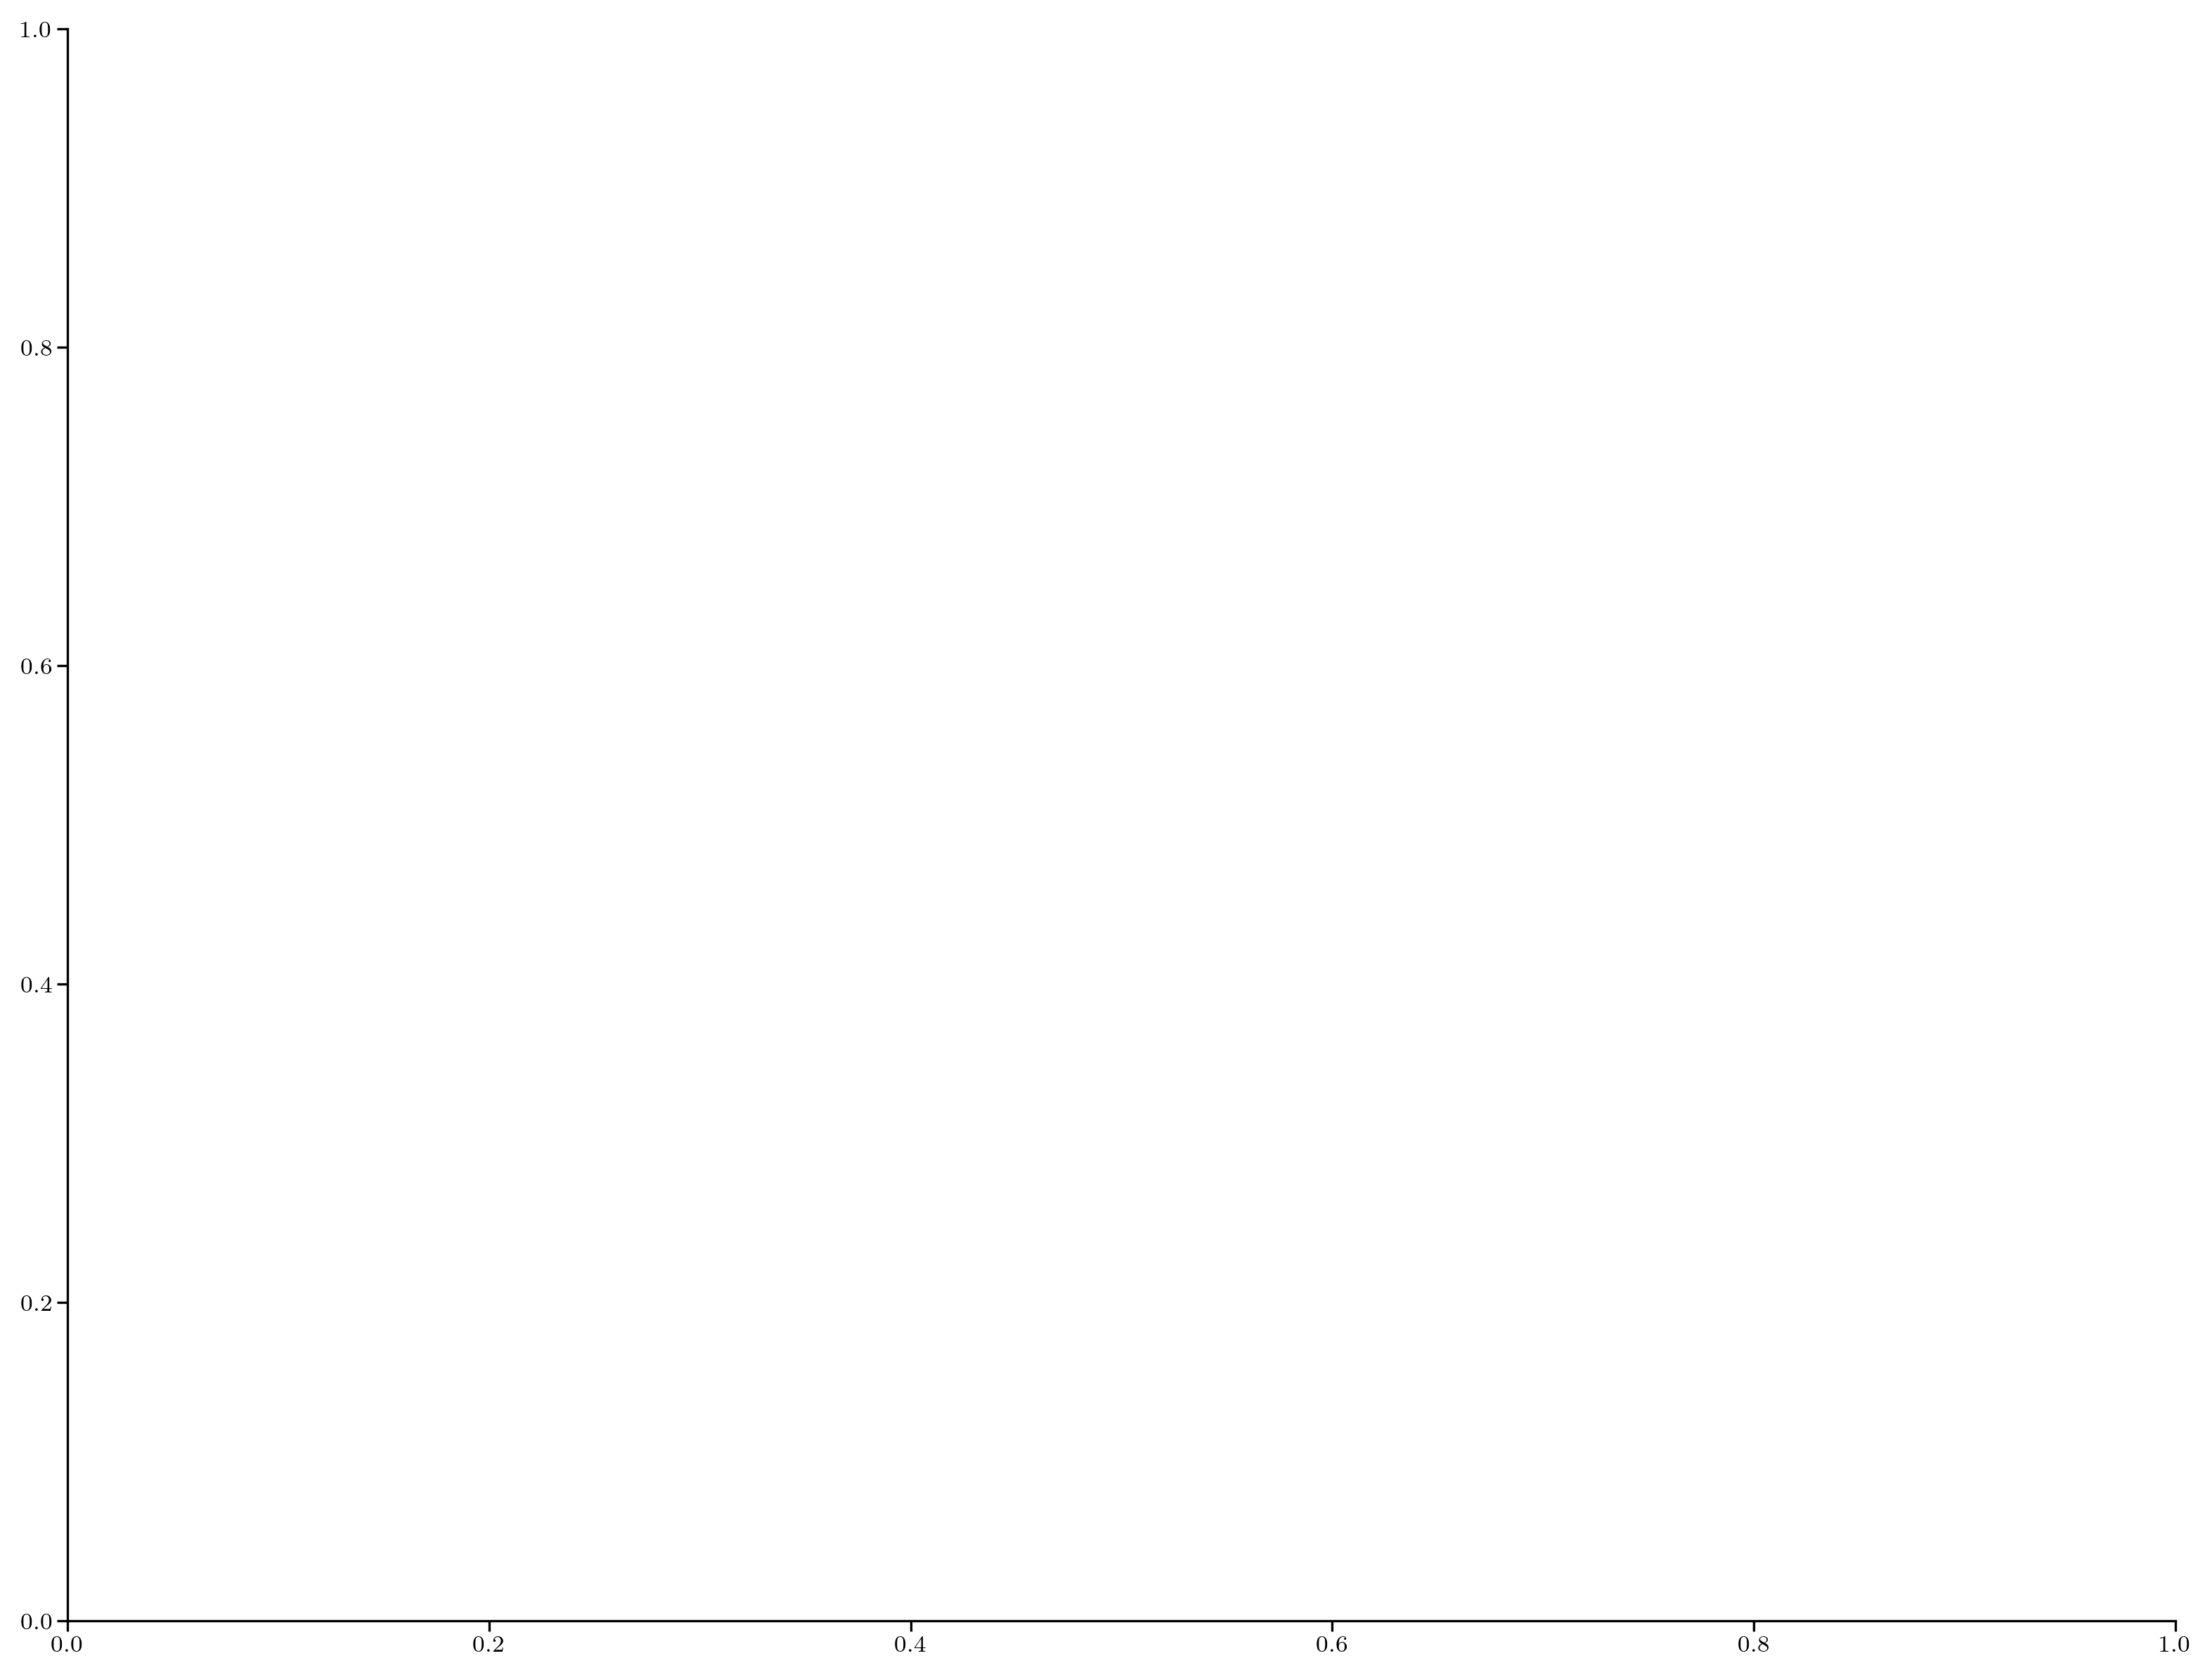

In [227]:
fig, ax = display_weights(W_orth)
plt.show()

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.1149e-03, -2.5410e-05,  3.9730e-05,  ..., -2.1896e-03,
         -1.1601e-05, -1.9906e-05],
        [-1.2149e-03, -2.9094e-05,  2.0285e-07,  ..., -7.0771e-03,
         -3.6838e-05, -6.2476e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')